# Plot velocity along circumpolar 1km isobath

This script:

1. Plots the along-slope and cross-slope velocity along the 1 km isobath together with ASC classification.
2. The velocity (10 year climatology, 2080-2089) on the 1 km isobath is selected and saved in `Calc_u_on_depth_contour.ipynb` and is loaded in here.
3. The ASC regime classification is calculated in `Calc_ASC_regimes.ipynb` and the ASF regime classification is calculated in `Calc_ASF_regimes.ipynb`. 

Load modules:

In [20]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
from cosima_cookbook import distributed as ccd
# Optional modules
import cmocean as cm
import matplotlib.gridspec as gridspec
import xarray.ufuncs as xu
import xgcm
import matplotlib.colors as colors
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [2]:
client = Client() # n_workers=8
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45889,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://10.0.128.143:34887,Total threads: 2
Dashboard: /proxy/33897/status,Memory: 5.62 GiB
Nanny: tcp://127.0.0.1:33461,


Nominate a database from which to load the data and define an experiment:

In [3]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Load data

In [4]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']#, 'annual']

Velocity along 1 km contour

In [5]:
data_path = '/g/data/x77/wgh581/Post_Process/'
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'

data = np.load(data_path + file_name)
data.files

['u_along_contour',
 'v_cross_contour',
 'u_btr_contour',
 'v_btr_contour',
 'lat_along_contour',
 'lon_along_contour',
 'num_points',
 'distance_along_contour',
 'st_ocean',
 'thickness_contour']

In [6]:
u_along_contour = data['u_along_contour']
v_cross_contour = data['v_cross_contour']
u_btr_contour   = data['u_btr_contour']
v_btr_contour   = data['v_btr_contour']
# All on u-grid
num_points = data['num_points']
distance_along_contour = data['distance_along_contour']
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']
st_ocean = data['st_ocean']
thickness_contour = data['thickness_contour']

In [7]:
# If using *_plt_approach
distance_along_contour[-1] = distance_along_contour[-2]+1 

### Smoothing along the contour

In [8]:
# Function that smooths the data
def running_mean_2d(in_data, N):
    out_data = np.zeros((np.shape(in_data)[0],np.shape(in_data)[1]))
    for yy in range(np.shape(in_data)[0]):
        cumsum_tmp = np.nancumsum(np.insert(in_data[yy,:], 0, 0))
        out_data[yy,int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

def running_mean_1d(in_data, N):
    out_data = np.zeros((np.shape(in_data)[0]))
    cumsum_tmp = np.nancumsum(np.insert(in_data, 0, 0))
    out_data[int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

Along-slope component

In [9]:
N = 20

u_along_clim = np.zeros((np.size(u_along_contour,0), np.size(u_along_contour,1), np.size(u_along_contour,2)))
for tt in range(len(month)):
    u_along_clim[tt,:,:] = running_mean_2d(u_along_contour[tt,:,:], N)

u_btr_clim = np.zeros((np.size(u_btr_contour,0), np.size(u_btr_contour,1)))
for tt in range(len(month)):
    u_btr_clim[tt,:] = running_mean_1d(u_btr_contour[tt,:], N)

Cross-slope component

In [10]:
v_cross_clim = np.zeros((np.size(v_cross_contour,0), np.size(v_cross_contour,1), np.size(v_cross_contour,2)))
for tt in range(len(month)):
    v_cross_clim[tt,:,:] = running_mean_2d(v_cross_contour[tt,:,:], 40)

v_btr_clim = np.zeros((np.size(v_btr_contour,0), np.size(v_btr_contour,1)))
for tt in range(len(month)):
    v_btr_clim[tt,:] = running_mean_1d(v_btr_contour[tt,:], 40)

Fill the values at the beginning and end with their high resolution / unsmoothed values, respectively.

In [11]:
u_along_clim[:, :, :int(N/2)]  = u_along_contour[:,:,:int(N/2)]
u_along_clim[:, :, -int(N/2):] = u_along_contour[:,:,-int(N/2):]

v_cross_clim[:, :, :int(N/2)]  = v_cross_contour[:,:,:int(N/2)]
v_cross_clim[:, :, -int(N/2):] = v_cross_contour[:,:,-int(N/2):]

In [12]:
u_btr_annual = np.mean(u_btr_clim, axis=0)
v_btr_annual = np.mean(v_btr_clim, axis=0)

### Prepare plotting

Load bathymetry

In [13]:
lat_slice = slice(-80, -59)

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)

# Select latitude range
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

Land mask

In [14]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

Paths, colormaps, ...

In [57]:
ft_size = 22
fig_path = '/g/data/x77/wgh581/Figures/'

# Font size
plt.rcParams['font.size'] = 22
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

In [16]:
# Costum colormap
import matplotlib
colorsList_no4 = [('lightgreen'),('blueviolet'),('tomato'),('c')]
CustomCmap_no4 = matplotlib.colors.ListedColormap(colorsList_no4)
colorsList_no3 = [('lightgreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

### Load ASC and ASF classifications

ASF classfification

In [17]:
# Load ASF classification (calculated in Calc_ASF_classification.ipynb)
file_path = '/g/data/x77/wgh581/Post_Process/Transects_ASF_classification/ASF_regimes_01deg_jra55v13_ryf9091_plt_approach.npz'
ASF_regimes = np.load(file_path)
ASF_regimes = ASF_regimes['ASF_regimes']
# Make the field 2d for plotting with pcolormesh
ASF_regimes_2d = np.vstack((ASF_regimes, ASF_regimes))

ASC classification

In [18]:
file_path = '/g/data/x77/wgh581/Post_Process/ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'
ASC_regimes_all = np.load(file_path)
ASC_regimes = ASC_regimes_all['ASC_regimes_annual']
#ASC_regimes_monthly = ASC_regimes_all['ASC_regimes_monthly']
ASC_regimes_2d = np.vstack((ASC_regimes, ASC_regimes))

### Plotting

#### Along-slope and cross-slope total and barotropic velocity

In [55]:
isobath_depth = 1000

def plot_along_cross_slope_contour(ii=0, save_fig=0):
    """
    ii: which data to plot (along-slope velocity=0, cross-slope velocity=1)
    save_fig: print the figure or save it?
    """
    
    fig = plt.figure(figsize=(20,10))
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.025], wspace=0.05)
    gs_tmp = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 0.85], subplot_spec=gs[0,0], hspace=0.25)
    
    # Depth against distance
    ax = fig.add_subplot(gs_tmp[0,0])
    if ii == 0:
        sc = plt.pcolormesh(distance_along_contour, st_ocean, u_along_clim.mean(axis=0), cmap='RdBu_r', vmin=-0.2, vmax=0.2)
        plt.title(r'$\bf{A}$ Total', loc='left')
    elif ii == 1:
        sc = plt.pcolormesh(distance_along_contour, st_ocean, v_cross_clim.mean(axis=0), cmap='RdBu_r', vmin=-0.02, vmax=0.02)
        plt.title(r'$\bf{A}$ Total', loc='left')
    plt.pcolormesh(distance_along_contour, [0,-100], ASC_regimes_2d, cmap=CustomCmap_no3)
    plt.pcolormesh(distance_along_contour, [-100,-200], ASF_regimes_2d, cmap=CustomCmap_no4)
    plt.ylim(isobath_depth, -200)
    plt.ylabel('Depth (m)')
    #plt.xticks(fontsize=ft_size-4)
    plt.xticks(ticks=np.arange(0, distance_along_contour[-1], 2500), labels=lon_along_contour[::500].round().astype(int))
    plt.xlabel('Longitude ($^{\circ}$E)')
    plt.yticks(np.arange(0, 1200, 200))
    plt.axhline(0, color='k', linewidth=1)
    plt.axhline(-100, color='k', linewidth=1)
    plt.text(100, -25, 'ASC regime', color='k', fontsize=ft_size-4)
    plt.text(100, -125, 'ASF regime', color='k', style='italic', fontsize=ft_size-4)
        
    # Map with 1000-m isobath
    ax = fig.add_subplot(gs_tmp[1,0])
    if ii == 0:
        sc = plt.scatter(lon_along_contour, lat_along_contour, c=u_btr_annual, vmin=-0.2, vmax=0.2, cmap='RdBu_r')
        plt.title(r'$\bf{B}$ Barotropic', loc='left')
    elif ii == 1:
        sc = plt.scatter(lon_along_contour, lat_along_contour, c=v_btr_clim.mean(axis=0), vmin=-0.02, vmax=0.02, cmap='RdBu_r')
        plt.title(r'$\bf{B}$ Barotropic', loc='left')
    plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
    plt.xlim(lon_along_contour.min(), lon_along_contour.max())
    plt.ylim(-80, -58)  
    plt.xlabel('Longitude ($^{\circ}$E)')
    plt.ylabel('Latitude ($^{\circ}$N)')
    #plt.xticks(fontsize=ft_size-4)
    plt.yticks(np.arange(-80, -59, 5))

    cbar_ax = fig.add_subplot(gs[0,1])
    cbar = plt.colorbar(sc, cax=cbar_ax, extend='both')
    if ii == 0:
        cbar.set_label('Along-slope velocity (m s$^{-1}$)')
    elif ii == 1:
        cbar.set_label('Cross-slope velocity (m s$^{-1}$)')
    #cbar.ax.tick_params(labelsize=ft_size-4)
    
    # Finished
    if save_fig == 1:
        if ii == 0:
            fig_name = 'Fig_along_mean_1000m_100percent_plt_approach_smoothed_50percent.png'
        elif ii == 1:
            fig_name = 'Fig_cross_mean_1000m_100percent_plt_approach_smoothed.png'
        plt.savefig(fig_path + fig_name)#, dpi=150, bbox_inches='tight', facecolor='white')
        
    return


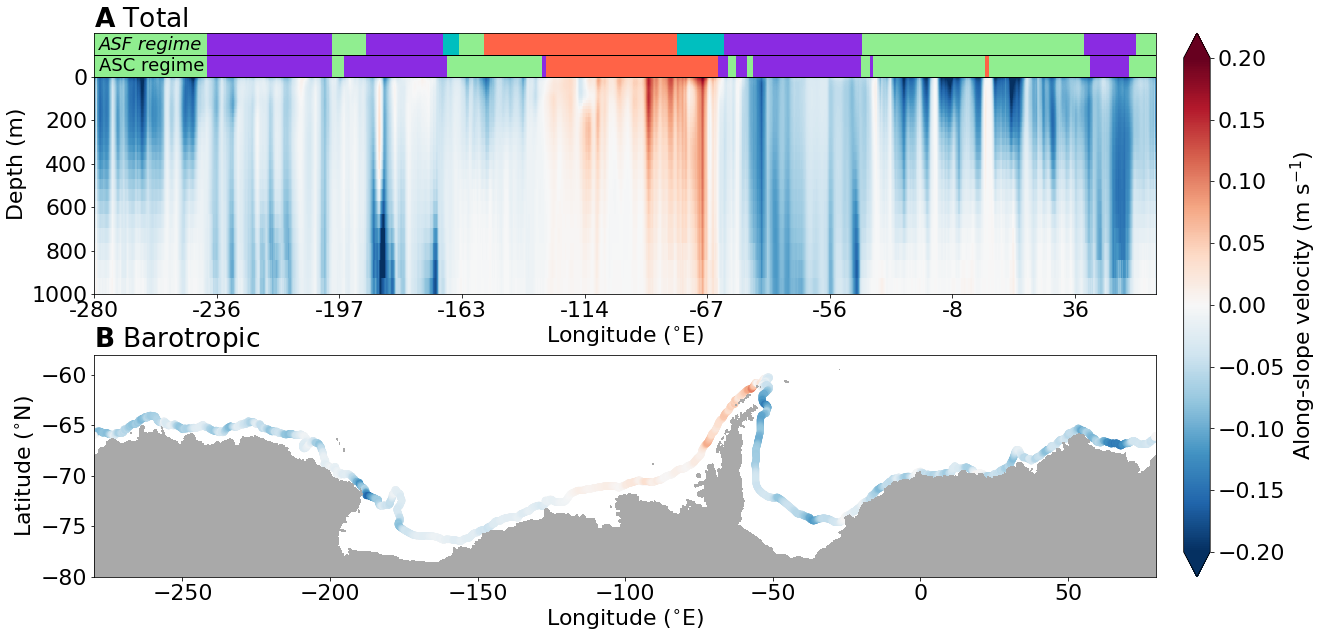

In [59]:
plot_along_cross_slope_contour(0, 1)

In [61]:
280-(113.3-80)

246.7

In [37]:
st_ocean_2d = np.zeros_like(thickness_contour)
for ii in range(np.size(st_ocean_2d, 1)):
    st_ocean_2d[:,ii] = st_ocean